In [53]:
import os
import torch
import torchvision
import tarfile
import numpy as np
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler as srs
from torch.utils.data.dataloader import DataLoader as dl
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
dataset_url = "https://files.fast.ai/data/examples/cifar10.tgz"
download_url(dataset_url,'.')

Using downloaded and verified file: .\cifar10.tgz


In [6]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [3]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['labels.txt', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
airplane_files = os.listdir(data_dir + '/train/airplane')
print('No. of training examples for airplanes: ', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes:  5000
['10008_airplane.png', '10010_airplane.png', '10020_airplane.png', '10024_airplane.png', '10031_airplane.png']


In [4]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())

In [10]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1,2,0))

Label:  airplane (0)


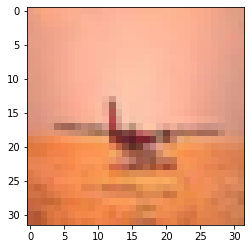

In [7]:
show_example(*dataset[1099])

In [24]:
def split_indices(n, val_pct=0.1, seed=99):
    n_val = int(val_pct * n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [27]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))
print('Sample validation indices: ', val_indices[:10])

40000 10000
Sample validation indices:  [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [31]:
batch_size = 100

train_sampler = srs(train_indices)
train_dl = dl(dataset, batch_size, sampler=train_sampler)

val_sampler = srs(val_indices)
val_dl = dl(dataset, batch_size, sampler=val_sampler)

In [51]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        print(fig)
        print(ax)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images,10).permute(1,2,0))
        break

Figure(720x720)
AxesSubplot(0.125,0.125;0.775x0.755)


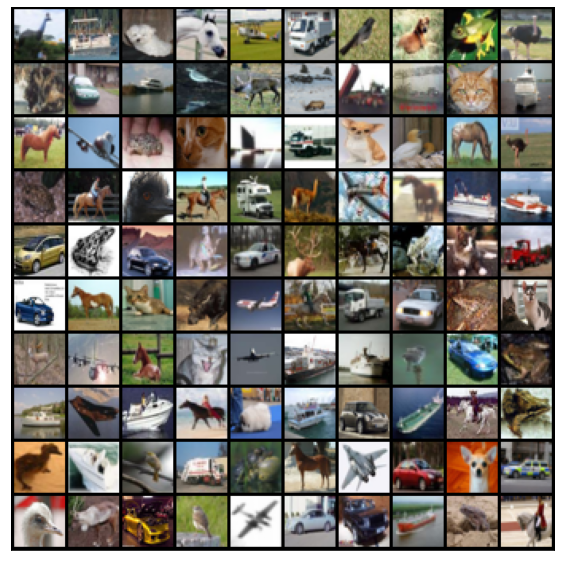

In [52]:
show_batch(train_dl)

In [106]:
simple_model = nn.Sequential(
                nn.Conv2d(3,8, kernel_size=3, stride=1, padding=1), 
                nn.MaxPool2d(2,2))

In [107]:
for images , labels in train_dl:
    print('images.shape: ', images.shape)
    out = simple_model(images)
    print('out.shape: ', out.shape)
    break

images.shape:  torch.Size([100, 3, 32, 32])
out.shape:  torch.Size([100, 8, 16, 16])


In [277]:
model = nn.Sequential(nn.Conv2d(3,16, kernel_size=3, stride=1, padding=1), 
                      nn.ReLU(),
                      nn.MaxPool2d(2,2), #output: bs x 16 x 16 x 16
                     
                      nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1), 
                      nn.ReLU(),
                      nn.MaxPool2d(2,2), #output: bs x 16 x 8 x 8
                      
                      nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1), 
                      nn.ReLU(),
                      nn.MaxPool2d(2,2), #output: bs x 16 x 4 x 4
                      
                      nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), 
                      nn.ReLU(),
                      nn.MaxPool2d(2,2), #output: bs x 16 x 2 x 2
                      
                      nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1), 
                      nn.ReLU(),
                      nn.MaxPool2d(2,2), #output: bs x 16 x 1 x 1
                      
                      nn.Flatten(), #output bs x 16
                      nn.Linear(256,10) #output : bs x 10
                     )

In [113]:
print(model[0].weight.shape)
print(model[3].weight.shape)
print(model[6].weight.shape)
print(model[9].weight.shape)
print(model[12].weight.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16, 16, 3, 3])
torch.Size([16, 16, 3, 3])
torch.Size([16, 16, 3, 3])
torch.Size([16, 16, 3, 3])


In [115]:
for images , labels in train_dl:
    #print(len(images))
    #for n in images:
     #   print(n)
    print('images.shape: ', images.shape)
    out = model(images)
    print('out.shape: ', out[0])
    break

images.shape:  torch.Size([100, 3, 32, 32])
out.shape:  tensor([ 0.0913,  0.2537,  0.1774, -0.2031, -0.1401, -0.1740, -0.1903, -0.1176,
         0.1659, -0.1460], grad_fn=<SelectBackward0>)


In [131]:
probs = F.softmax(out[0], dim = 0)
out[0],torch.sum(probs), probs


(tensor([ 0.0913,  0.2537,  0.1774, -0.2031, -0.1401, -0.1740, -0.1903, -0.1176,
          0.1659, -0.1460], grad_fn=<SelectBackward0>),
 tensor(1.0000, grad_fn=<SumBackward0>),
 tensor([0.1111, 0.1306, 0.1211, 0.0827, 0.0881, 0.0852, 0.0838, 0.0901, 0.1197,
         0.0876], grad_fn=<SoftmaxBackward0>))

In [137]:
v, x = torch.max(probs, dim= 0)
x

tensor(1)

In [143]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
    
    #Generate predictions
    preds = model(xb)
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None :
        # Compute gradients
        loss.backward()
        #Update parameters
        opt.step()
        #Reset gradients
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        #Compute the metric
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result

In [144]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    #print('Comparison : {}'.format(torch.sum(preds==labels).item()))
    #print('Total Preds : {}'.format(len(preds)))
    return torch.sum(preds==labels).item()/len(preds)

In [219]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl, metric = None, opt_fn = None):
    train_losses, val_losses, val_metrics = [],[], []
    
    
    #Instantiate the optimizer
    if opt_fn is None: 
        opt_fn = torch.optim.SGD
    
    opt = opt_fn(model.parameters(), lr=lr)
 
    for epoch in range(epochs):
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _,_ = loss_batch(model, loss_fn, xb, yb, opt)
            #train_losses.append(train_loss)
        
        
        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result
        
        #Record the loss & metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        #Print progress
        if metric is None:
            print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, val_{}: {:.4f}'.format(epoch+1, epochs, train_loss, 
                                                                 val_loss, metric.__name__,val_metric))
            
    return train_losses, val_losses, val_metrics

In [185]:
def evaluate(model, loss_fn, valid_dl, metric = None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) 
                   for xb,yb in valid_dl]
        
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
    
    return avg_loss, total, avg_metric

In [278]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric=accuracy)

In [279]:
val_loss, val_acc

(2.303684117794037, 0.1021)

In [289]:
num_epochs = 15
opt_fn = torch.optim.Adam
lr = 0.001

batch_size = 100

val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split_indices(len(dataset), val_pct, rand_seed)


train_sampler = srs(train_indices)
train_dl = dl(dataset, batch_size, sampler=train_sampler)

val_sampler = srs(val_indices)
val_dl = dl(dataset, batch_size, sampler=val_sampler)

len(train_dl)
len(val_dl)
len(train_indices)
len(dataset)

50000

In [285]:
history = fit(num_epochs, lr, model, F.cross_entropy, train_dl, val_dl, accuracy, opt_fn)
train_losses, val_losses, val_metrics = history

Epoch [1/15], Train Loss: 0.4677, Val Loss: 1.0152, val_accuracy: 0.7056
Epoch [2/15], Train Loss: 0.3810, Val Loss: 1.0425, val_accuracy: 0.7039
Epoch [3/15], Train Loss: 0.3923, Val Loss: 1.1627, val_accuracy: 0.6995
Epoch [4/15], Train Loss: 0.2152, Val Loss: 1.1837, val_accuracy: 0.7045
Epoch [5/15], Train Loss: 0.1324, Val Loss: 1.2469, val_accuracy: 0.6997
Epoch [6/15], Train Loss: 0.1644, Val Loss: 1.3557, val_accuracy: 0.6968
Epoch [7/15], Train Loss: 0.1493, Val Loss: 1.4053, val_accuracy: 0.6957
Epoch [8/15], Train Loss: 0.1532, Val Loss: 1.4777, val_accuracy: 0.7018
Epoch [9/15], Train Loss: 0.2012, Val Loss: 1.5139, val_accuracy: 0.7038
Epoch [10/15], Train Loss: 0.2003, Val Loss: 1.5858, val_accuracy: 0.6992
Epoch [11/15], Train Loss: 0.2396, Val Loss: 1.6576, val_accuracy: 0.7045
Epoch [12/15], Train Loss: 0.0969, Val Loss: 1.7193, val_accuracy: 0.6934
Epoch [13/15], Train Loss: 0.1311, Val Loss: 1.7532, val_accuracy: 0.6977
Epoch [14/15], Train Loss: 0.1814, Val Loss: 1.

In [282]:
len(train_losses)

15

In [157]:
def plot_metric(metric_values):
    """Plot metric values in a line graph"""
    plt.plot(metric_values, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

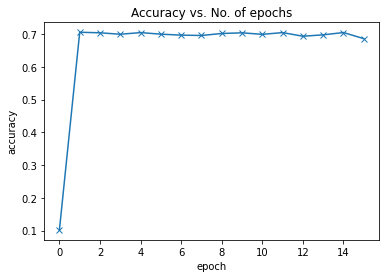

In [286]:
plot_metric([val_acc] + val_metrics)

In [176]:
def plot_losses(train_losses, val_losses):
    
    plt.plot(train_losses, '-x')
    plt.plot(val_losses, '-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

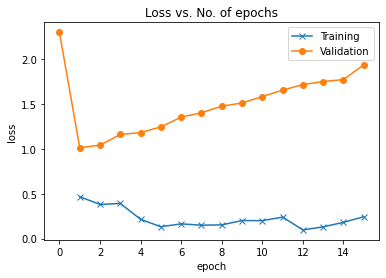

In [287]:
plot_losses([None] + train_losses, [val_loss] + val_losses)

In [237]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [238]:
def predict_image(img, model):
    #Convert to a batch of 1
    xb = img.unsqueeze(0)
    #Get predictions from model
    yb = model(xb)
    #Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    #Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: bird


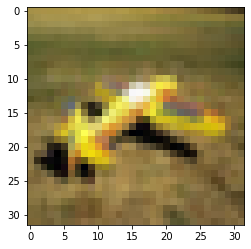

In [244]:
img, label = test_dataset[5]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label],', Predicted:', predict_image(img, model))

In [249]:
test_loader = dl(test_dataset, batch_size)

test_loss, _, test_acc = evaluate(model, F.cross_entropy,test_loader, metric = accuracy)
print('Loss: {:.4f}, Accuracy: {:4f}'.format(test_loss, test_acc))

Loss: 1.0318, Accuracy: 0.637900
